# Library Import

In [34]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import statsmodels.api as sm

# Dataset Import

* Name: Song Popularity Dataset
* Source: kaggle
* Url: https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

Humans have greatly associated themselves with Songs & Music. It can improve mood, decrease pain and anxiety, and facilitate opportunities for emotional expression. Research suggests that music can benefit our physical and mental health in numerous ways.

Lately, multiple studies have been carried out to understand songs & it's popularity based on certain factors. Such song samples are broken down & their parameters are recorded to tabulate. Predicting the Song Popularity is the main aim.

The project is simple yet challenging, to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. The dataset is large & it's complexity arises due to the fact that it has strong multicollinearity. Can you overcome these obstacles & build a decent predictive model?

In [35]:
song_df = pd.read_csv('song_data.csv')
song_df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


# 1. About the data

The goal of the dataset is to predict the popularity of a song based on qualitative and quantitative characteristics of the song, so song_popularity will be used as the y_column.

In [36]:
Y_COLUMN = 'song_popularity'

There are a few columns whose definition weren't immediately obvious, so I referred to Spotify's API in order to get more clarification as to what the data and values. represent.

https://developer.spotify.com/documentation/web-api/reference/get-audio-features

* acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* dancability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* audio_mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* audio_valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

Given the above descriptions, and the hint given in the data descriptions, it is likely that a number of these variables will be correlated (audio_mode and audio_valence, as the Major scale is generally considered to be used to "happy" music and vice versa). I will conduct an analysis of this in order to attempt to identify any colinearity between variables prior to performing regression.

## 1.1 missing data and preprocessing

Goal of this section is to perform a general analysis of the dataset, including checks for NA and / or valid data types.

In [37]:
song_df.isna().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [38]:
song_df.dtypes

song_name            object
song_popularity       int64
song_duration_ms      int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature        int64
audio_valence       float64
dtype: object

All of the dtypes are in line with what is expected, with song name being strings, and the rest being int64 or float64 values.

## 1.2 song_popularity data distribution

Will do a quick analysis of the song_popularity column, which represents the y value of the regression.

In [39]:
song_popularity = song_df[Y_COLUMN]

In [40]:
song_popularity.describe()

count    18835.000000
mean        52.991877
std         21.905654
min          0.000000
25%         40.000000
50%         56.000000
75%         69.000000
max        100.000000
Name: song_popularity, dtype: float64

<Axes: xlabel='song_popularity', ylabel='Count'>

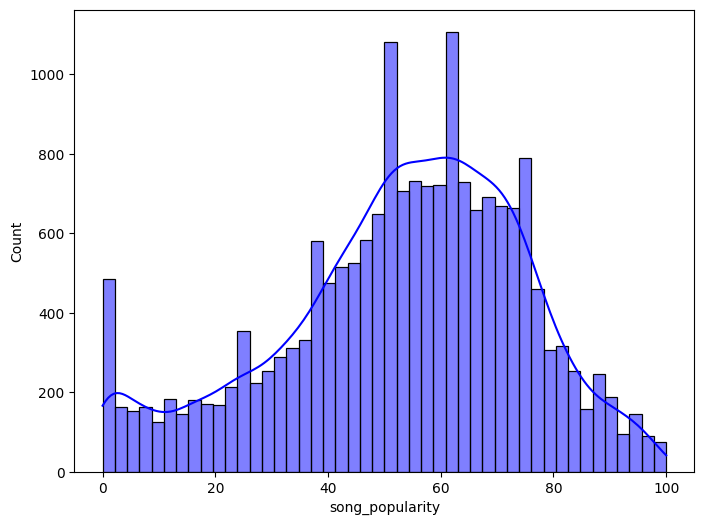

In [41]:
plt.figure(figsize=(8, 6))
sb.histplot(song_popularity, color='b', kde=True)

The above distribution indicates a slight negative skew to the song_popularity, which a larger proportion of datapoints being over the 50% threshold of song popularity.

## 1.3 Data analysis

Now I am going to analysis the rest of the dataset excluding song_popularity (which is the y axis), as well as song_name, as this isn't relevant in the regression.

In [42]:
cur_X = song_df.drop([Y_COLUMN, 'song_name'], axis=1)
cur_X

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>],
       [<Axes: title={'center': 'audio_mode'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>],
       [<Axes: title={'center': 'audio_valence'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

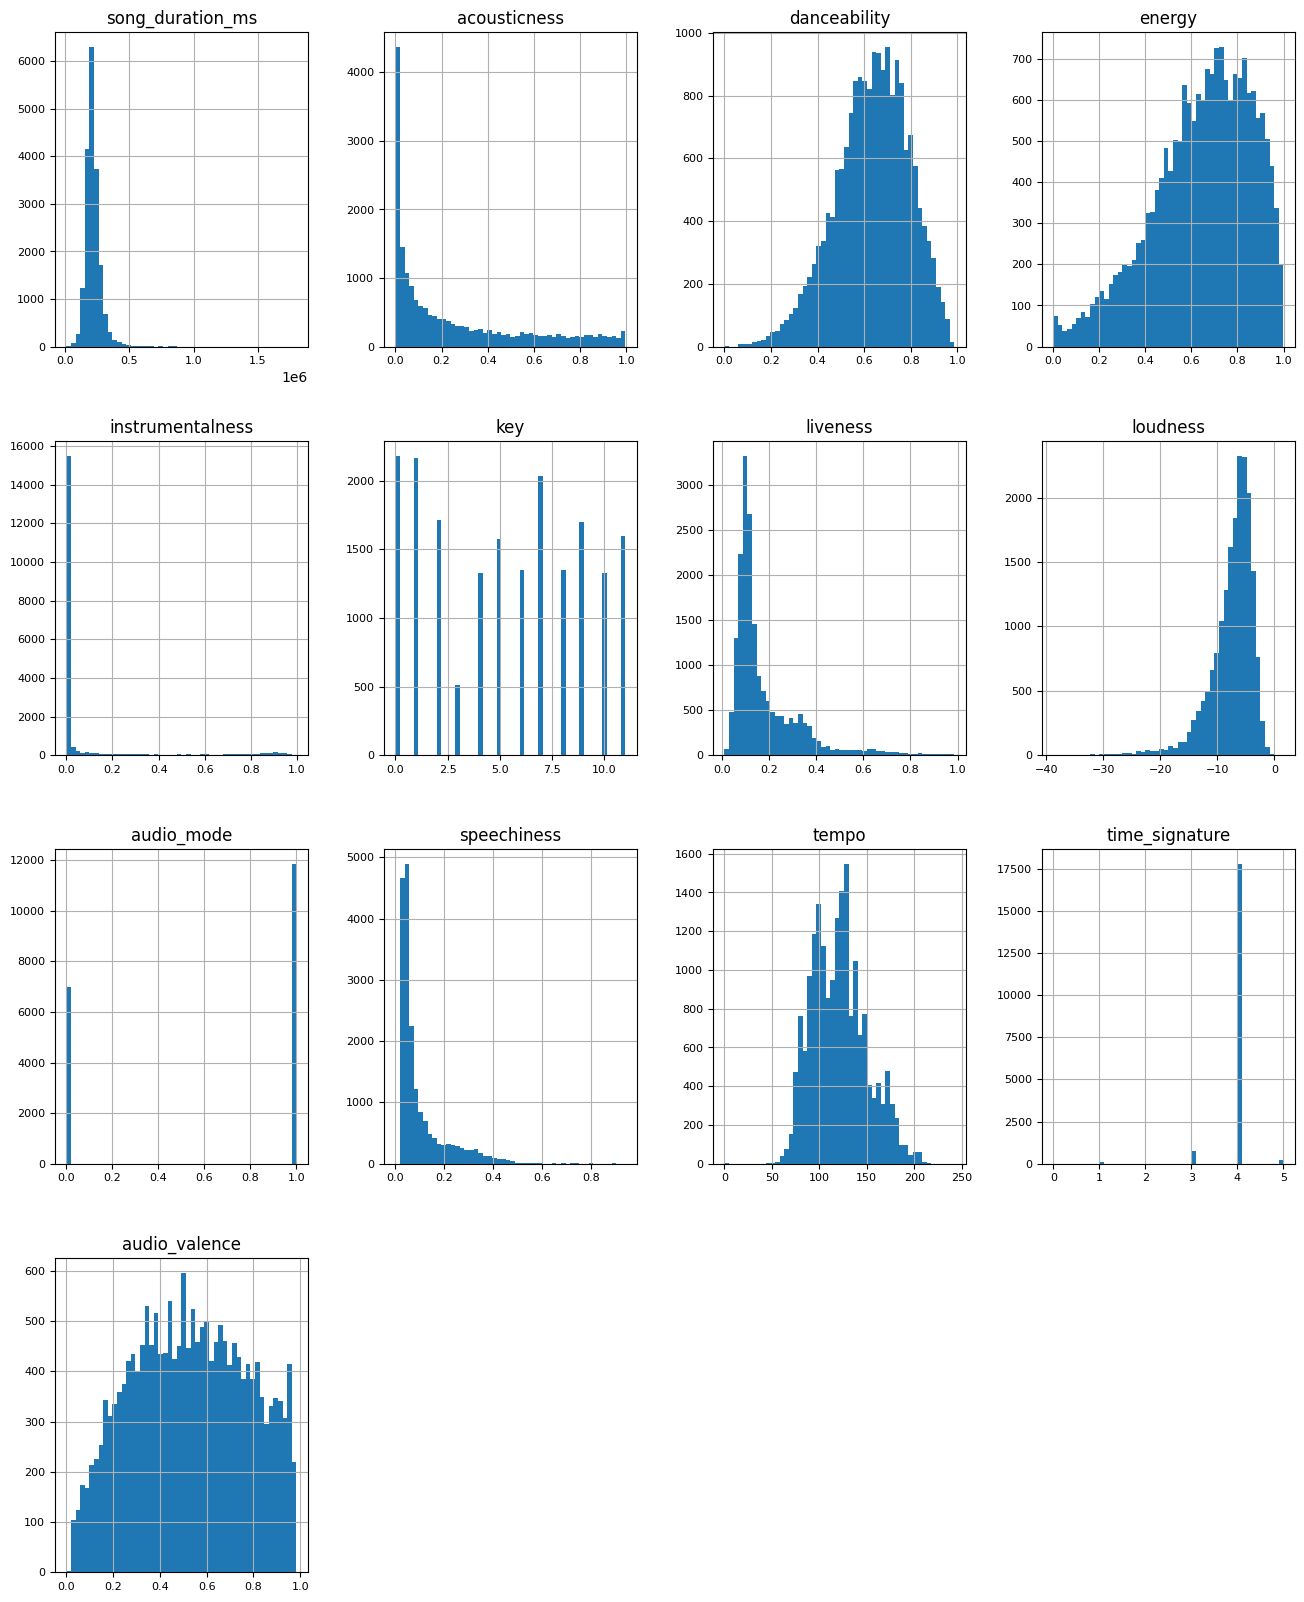

In [43]:
cur_X.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

## 1.3 Conversion from Numerical to Categorical

There are some variables which are currently presented as numerical, but could potentially be converted to be one hot encoded based on the description. Speechiness is a prime candidate. The data definition has essentially split the variable into three categories based on the score; spoken-word, rap, and music. It is worth exploring whether more of these variables can be converted to be one-hot encoded.

In [44]:
speechiness_df = cur_X[['speechiness']]
speechiness_df

,speechiness
0,0.0294
1,0.0498
2,0.0792
3,0.1070
4,0.0313
...,...
18830,0.0348
18831,0.0301
18832,0.0355
18833,0.0328


In [45]:
def liveness_to_rank(col):
    if col > 0.8:
        return 1
    else:
        return 0

def speechiness_to_rank(col):
    if col < 0.33:
        return 1
    elif col >= 0.33 and col < 0.66:
        return 2
    else:
        return 3

In [46]:
song_df['speechiness_category'] = song_df['speechiness'].apply(speechiness_to_rank)
song_df['liveness_category'] = song_df['liveness'].apply(liveness_to_rank)

In [47]:
song_df['speechiness_category'].value_counts()

speechiness_category
1    17829
2      967
3       39
Name: count, dtype: int64

In [48]:
song_df['liveness_category'].value_counts()

liveness_category
0    18711
1      124
Name: count, dtype: int64

In [49]:
song_df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,speechiness_category,liveness_category
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474,1,0
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370,1,0
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324,1,0
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198,1,0
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574,1,0


## 1.4 Variable Correlation analysis

In [50]:
def plot_correlation_matrix(df: pd.DataFrame):
    """_summary_

    Args:
        df (pd.DataFrame): _description_
    """
    fig = plt.figure()
    n_ticks = np.arange(len(df.columns))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(n_ticks)
    ax.set_yticks(n_ticks)
    ax.set_xticklabels(df.columns, rotation=270)
    ax.set_yticklabels(df.columns)
    ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
    ax.yaxis.set_major_locator(tkr.MultipleLocator(1))
    plt.show()

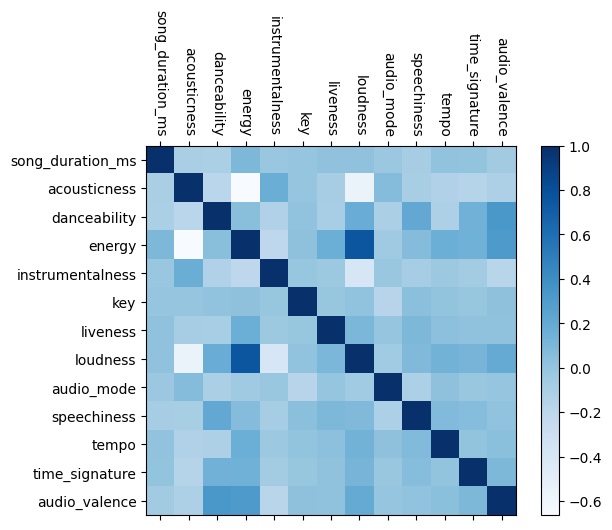

In [51]:
plot_correlation_matrix(cur_X)

According to the above, the most highly correlated variables are energy/loudness, and audio_valence/energy and audio_valence/danceability. audio_mode has shown little to now correlation with the rest of the variables, but I will confirm that by splitting the dataset based on whether it is Major or Minor.

In [52]:
audio_mode_col = 'audio_mode'

In [53]:
major_mask = (cur_X[audio_mode_col] == 1)

In [54]:
major_songs = cur_X[major_mask].drop(audio_mode_col, axis=1)
minor_songs = cur_X[~major_mask].drop(audio_mode_col, axis=1)

In [55]:
major_songs.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,audio_valence
count,1.183100e+04,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000,11831.000000
mean,2.169985e+05,0.272778,0.620501,0.636494,0.075454,4.816837,0.179536,-7.619743,0.093134,121.524910,3.953596,0.527109
std,5.943878e+04,0.298629,0.157728,0.220320,0.217691,3.591481,0.145678,3.921460,0.097006,28.995752,0.312804,0.247239
min,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.014800,-38.768000,0.000000,0.000000,0.000000,0.000000
25%,1.819130e+05,0.023800,0.520000,0.495000,0.000000,1.000000,0.092800,-9.343000,0.035900,99.242500,4.000000,0.329000
50%,2.101320e+05,0.145000,0.630000,0.666000,0.000010,5.000000,0.121000,-6.682000,0.050900,120.022000,4.000000,0.524000
75%,2.418400e+05,0.462500,0.735000,0.812500,0.002470,8.000000,0.219000,-4.995000,0.103000,139.981000,4.000000,0.728000
max,1.355938e+06,0.996000,0.981000,0.999000,0.982000,11.000000,0.986000,0.878000,0.936000,213.990000,5.000000,0.984000


array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'key'}>],
       [<Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'audio_valence'}>]], dtype=object)

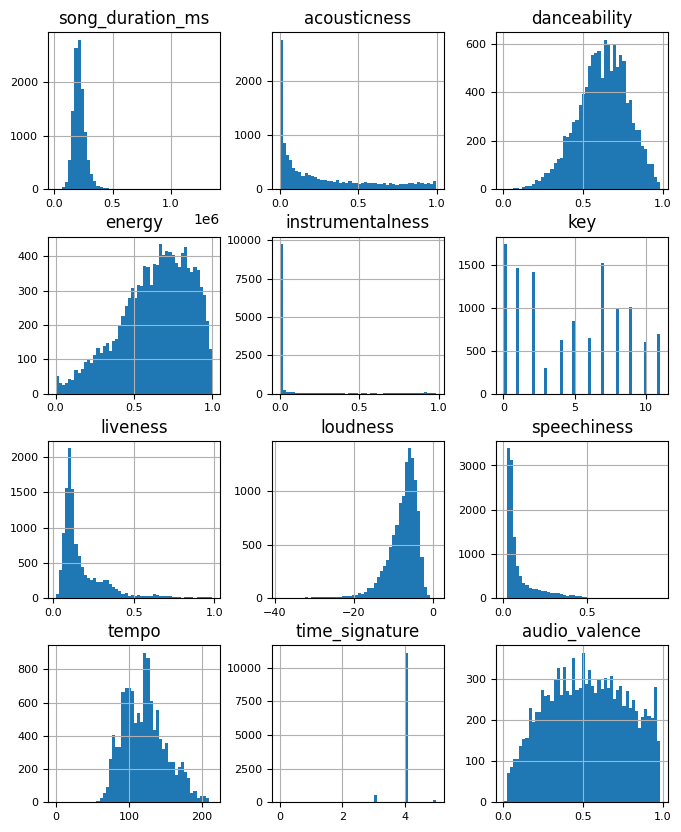

In [56]:
major_songs.hist(figsize=(8, 10), bins=50, xlabelsize=8, ylabelsize=8)

In [57]:
minor_songs.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,audio_valence
count,7.004000e+03,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000,7004.000000
mean,2.202608e+05,0.234486,0.655048,0.659354,0.082323,6.087093,0.179844,-7.156375,0.117242,120.310059,3.968447,0.529416
std,6.058714e+04,0.269475,0.152583,0.202369,0.227976,3.512099,0.141087,3.646071,0.114190,28.218565,0.272503,0.240174
min,5.057300e+04,0.000003,0.066000,0.004580,0.000000,0.000000,0.010900,-36.729000,0.022800,47.953000,1.000000,0.029200
25%,1.886660e+05,0.024575,0.560000,0.537000,0.000000,4.000000,0.093100,-8.506500,0.041900,97.976500,4.000000,0.343000
50%,2.129730e+05,0.118000,0.668000,0.688000,0.000013,6.000000,0.123000,-6.354500,0.066400,120.012000,4.000000,0.532000
75%,2.440260e+05,0.360250,0.768000,0.818000,0.002810,9.000000,0.226000,-4.808000,0.147000,138.216000,4.000000,0.720000
max,1.799346e+06,0.996000,0.987000,0.997000,0.997000,11.000000,0.983000,1.585000,0.941000,242.318000,5.000000,0.982000


array([[<Axes: title={'center': 'song_duration_ms'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'key'}>],
       [<Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>,
        <Axes: title={'center': 'audio_valence'}>]], dtype=object)

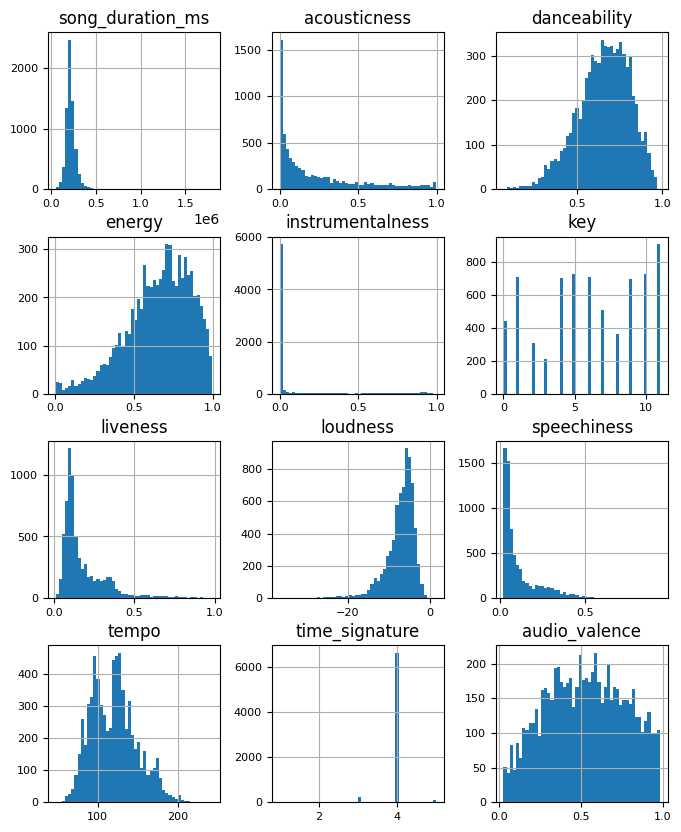

In [58]:
minor_songs.hist(figsize=(8, 10), bins=50, xlabelsize=8, ylabelsize=8)

## 1.7 Data Analysis Conclusion

There are a number of conclusions which can be drawn based on the above distributions:

* 1. Categorical Data: key, audio_mode and time_signature appear to be categorical values, and so will be encoded accordingly.
* 2. Varied shewness: the rest of the columns vary between being normally distributed, to exhibiting positive and negative skewness, so normalization will be needed to perform regression.
* 3. Correlation in variables: danceability and energy have very similar distributions, so i will be interesting to determine if there are any correlation between these variables after regression.

# 2. Objective

The objective of this workbook is to determine the most significant qualitative and quantitative features required to predict the popularity of a song.

# 3. Data Preprocessing
The ultimate aim of this section is to create the sklearn Pipeline objects which will be used to train the various models which will be used to predict song popularity.

In [59]:
columns_to_drop = [Y_COLUMN, 'song_name']
X = song_df.drop(columns_to_drop, axis=1)
y = song_df[Y_COLUMN]

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 3.1 Converting Numerical Columns to Categorical

## 3.2  Preprocessor Definitions

I am going to first define the preprocessing pipeline which will used for the standard Linear Regression model.

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [81]:
#binary_cols = ['time_signature']
categorical_cols = ['key', 'speechiness_category', 'liveness_category']
numerical_cols = [col for col in X.columns if col not in categorical_cols and col not in binary_cols]
numerical_cols

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'audio_valence']

In [82]:
numerical_transformer = Pipeline(
    steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ss', StandardScaler())
    ]
)

In [83]:
categorical_transformer = Pipeline(
    steps=[
        ('one_hot', OneHotEncoder())
    ]
)

In [84]:
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, categorical_cols),
        ('numerical_transformer', numerical_transformer, numerical_cols),
    ]
)

# 4. Feature Selection

As mentioned in the earlier analysis, some of the features exhibit high correlation, so we will need to look at ways of resolving this.

In [85]:
transformed_cols = column_transformer.fit_transform(X)
column_names = column_transformer.get_feature_names_out()

In [86]:
column_names

array(['categorical_transformer__key_0', 'categorical_transformer__key_1',
       'categorical_transformer__key_2', 'categorical_transformer__key_3',
       'categorical_transformer__key_4', 'categorical_transformer__key_5',
       'categorical_transformer__key_6', 'categorical_transformer__key_7',
       'categorical_transformer__key_8', 'categorical_transformer__key_9',
       'categorical_transformer__key_10',
       'categorical_transformer__key_11',
       'categorical_transformer__speechiness_category_1',
       'categorical_transformer__speechiness_category_2',
       'categorical_transformer__speechiness_category_3',
       'categorical_transformer__liveness_category_0',
       'categorical_transformer__liveness_category_1',
       'numerical_transformer__song_duration_ms',
       'numerical_transformer__acousticness',
       'numerical_transformer__danceability',
       'numerical_transformer__energy',
       'numerical_transformer__instrumentalness',
       'numerical_transfo

## 4.1 Feature Selection using p-value

In feature selection, you typically start with the null hypothesis (H0) that there is no significant relationship between the feature and the target variable.
The alternative hypothesis (Ha) is that there is a significant relationship between the feature and the target variable.

https://tracyrenee61.medium.com/how-i-used-feature-selection-and-statsmodels-to-solve-kaggles-house-price-competition-df6907202521

In [87]:
model_ols = sm.OLS(y, transformed_cols, formula=f"{Y_COLUMN} ~ {' + '.join(col for col in column_names)}")
results = model_ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     20.62
Date:                Tue, 07 May 2024   Prob (F-statistic):          1.38e-310
Time:                        20:43:52   Log-Likelihood:                -83975.
No. Observations:               18835   AIC:                         1.681e+05
Df Residuals:                   18744   BIC:                         1.688e+05
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.6897      0.520      9.021      0.0

## 4.2 Feature Selection using VIF

I will use statsmodels variance_inflation_factor to determine the level of colinearity 

A large VIF on an independent variable indicates a highly collinear relationship to the other variables that should be considered or adjusted for in the structure of the model and selection of independent variables.

VIF > 10, then we should definitely eliminate the variable.
VIF > 5, We need to inspect the variable before eliminating it.
VIF < 5, is definitely a good variable and we should not eliminate it.

https://medium.com/@rasdhar.panchal/feature-selection-using-p-values-and-vif-in-linear-regression-6bf25b652d99

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['columns'] = column_names
vif_data['vif'] = [variance_inflation_factor(transformed_cols, i) for i in range(transformed_cols.shape[1])]
vif_data

/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


KeyboardInterrupt: 

In [142]:
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2

In [143]:
feature_selection = Pipeline(
    steps=[
        ('variance_threshold', VarianceThreshold(threshold=0.25)),
        ('select_percentile', SelectPercentile(chi2, percentile=99)),
    ]
)

## 4.2 Colinearity

This section relates to handling colinearity within the features

# 5. Model Selection and Training

## 5.1 Polynomial Features Hyperparamter Tuning

I have defined the below method which will be used to determine the optimal degree parameter for the above dataset. It essentially trains and evaluates a vanilla Polynomial Regression for a range of degrees, and plots the calculated rmse score for each value.

In [144]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def plot_rmse(x_values: np.array, x_label: str, rmse_scores: np.array):
    """Plots rmse scores against user defined x parameters

    Args:
        x_value (np.array): _description_
        x_label (str): _description_
        rmse_scores (np.array): _description_
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_values, rmse_scores)
    ax.set_yscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylabel('rmse')


def fit_and_plot_optimal_polynomial_degrees(X_train: np.array,
                                            X_test: np.array,
                                            y_train: np.array,
                                            y_test: np.array,
                                            min_degree=1,
                                            max_degree=10):
    """_summary_

    Args:
        X_train (np.array): _description_
        X_test (np.array): _description_
        y_train (np.array): _description_
        y_test (np.array): _description_
        min_degree (int, optional): _description_. Defaults to 1.
        max_degree (int, optional): _description_. Defaults to 10.
    """
    degrees = np.arange(1, 10)
    rmses = []
    min_rmse, min_degree = 1e10, 0
    
    for degree in degrees:
        pipeline = Pipeline(
            steps=[
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                ('lr', LinearRegression())
            ]
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        if rmse < min_rmse:
            rmses.append(rmse)
            min_rmse = rmse
            min_degree = degree
    print(f"optimal_degree: {min_degree}")
    plot_rmse(degrees, 'degree', rmses)


def rss(y_true, y_pred):
    """_summary_

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.sum(np.square(y_true, y_pred))


def root_mean_squared_error(y_true, y_pred):
    """_summary_

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

Uncommenting the method below will run the hyperparameter tuning for PolynomialFeatures.

In [145]:
#fit_and_plot_optimal_polynomial_degrees(X_train, X_test, y_train, y_test, min_degree=2, max_degree=4)

## 5.2 Model Definition and Training

In [146]:
lr = Pipeline(
    steps=[
        ('column_transformer', column_transformer),
        ('model', LinearRegression())
    ]
)

In [147]:
lasso = Pipeline(
    steps=[
        ('column_transformer', column_transformer),
        ('model', Lasso(alpha=0.01, max_iter=100000))
    ]
)

In [148]:
ridge = Pipeline(
    steps=[
        ('column_transformer', column_transformer),
        ('model', Ridge(alpha=0.01, max_iter=100000))
    ]
)

In [ ]:
polynomial = Pipeline(
    steps=[
        ('column_transformer', column_transformer),
        ('model', ElasticNet())
    ]
)

In [149]:
pipelines = [lr, lasso, ridge]

## 3.4 Model Training and Evaluation

In [150]:
model_rss = []
model_rmses = []
model_mses = []
model_r2_scores = []

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    model_rss.append(rss(y_test, y_pred))
    model_rmses.append(root_mean_squared_error(y_test, y_pred))
    model_mses.append(mean_squared_error(y_test, y_pred))
    model_r2_scores.append(r2_score(y_test, y_pred))

In [151]:
(pipelines[0][-1].coef_ != 0).sum()

99

In [152]:
(pipelines[1][-1].coef_ != 0).sum()

83

In [153]:
(pipelines[2][-1].coef_ != 0).sum()

99

In [154]:
model_r2_scores

[0.08753084998158644, 0.08802736809782852, 0.08753249662840046]

In [155]:
model_mses

[443.0279943347816, 442.78692160899664, 443.02719484404224]

In [156]:
model_rmses

[21.048230194835423, 21.042502741095145, 21.048211202951244]